In [27]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
8375353,QUEENSBERRY,HOWARD STREET,QUEENSBERRY STREET,VICTORIA STREET,1,C5896,07/06/2012 07:30:07 AM,07/06/2012 08:58:14 AM,5287,4P MTR M-F 7:30-18:30,0,798,3304
3308093,COURTNEY,ELIZABETH STREET,PELHAM STREET,QUEENSBERRY STREET,5,4775W,03/01/2012 03:53:31 PM,03/01/2012 04:01:17 PM,466,2P TKT A M-F 7:30-18:30,0,627,3225
853107,QUEENSBERRY,ERROL STREET,QUEENSBERRY STREET,VICTORIA STREET,5,10173W,25/10/2011 10:06:35 AM,25/10/2011 10:23:50 AM,1035,1P TKT A M-F 7:30-18:30,0,641,3100
10131001,RACV,QUEEN STREET,BOURKE STREET,LT COLLINS STREET,2,1116E,30/07/2012 07:41:13 AM,30/07/2012 07:43:26 AM,133,1/2P MTR M-F 7:30-16:30,0,1171,5397
11900859,COUNTY,LT BOURKE STREET,KING STREET,WILLIAM STREET,3,2608N,21/09/2012 07:30:08 AM,21/09/2012 01:57:12 PM,23224,1P TKT A M-SAT 7:30-19:30,1,907,7002


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
target = parkingdata['In Violation?']

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('In Violation?', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['Side Of Street'] = parkingdata['Side Of Street']
features['Duration of Parking Event (in seconds)'] = parkingdata['Duration of Parking Event (in seconds)']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,Side Of Street,Duration of Parking Event (in seconds),Street ID,Device ID,Arrival Hour,Departure Hour
8375353,0,0,0,0,0,1,5287,798,3304,7,8
3308093,1,1,1,1,1,5,466,627,3225,15,16
853107,0,2,0,0,2,5,1035,641,3100,10,10
10131001,2,3,2,2,3,2,133,1171,5397,7,7
11900859,3,4,3,3,4,3,23224,907,7002,7,13
5734041,0,5,3,4,5,3,654,1381,5540,9,9
2670591,3,6,3,3,6,4,74,894,1912,17,17
2496159,4,7,4,5,7,2,229,116,1725,16,16
5638092,5,8,5,6,8,4,125,856,2065,16,16
1578505,6,9,6,7,9,3,423,670,1098,11,11


In [8]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [10]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1676 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   17.9s finished


In [11]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'splitter': 'best'}

In [12]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  entropy
Best max_depth:  None
Best min_samples_leaf:  1
Best min_samples_split:  5
Best splitter:  best


In [13]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9217
556,entropy,15.0,10.0,14.0,best,0.9625
557,entropy,15.0,10.0,14.0,random,0.9231
558,entropy,15.0,10.0,16.0,best,0.9627


In [14]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [15]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.869
Score with 2 selected features: 0.8695
Score with 3 selected features: 0.9175
Score with 4 selected features: 0.9265
Score with 5 selected features: 0.9335
Score with 6 selected features: 0.9425

Indexs of the desired features
[2, 3, 6, 0, 7, 5]


In [16]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Between Street 2,Duration of Parking Event (in seconds),Area Name,Street ID,Side Of Street
8375353,0,0,5287,0,798,1
3308093,1,1,466,1,627,5
853107,0,0,1035,0,641,5
10131001,2,2,133,2,1171,2
11900859,3,3,23224,3,907,3
5734041,3,4,654,0,1381,3
2670591,3,3,74,3,894,4
2496159,4,5,229,4,116,2
5638092,5,6,125,5,856,4
1578505,6,7,423,6,670,3


In [17]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   11.5s finished


In [18]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'splitter': 'best'}

In [19]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  gini
Best max_depth:  15
Best min_samples_leaf:  4
Best min_samples_split:  5
Best splitter:  best


In [20]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9257
556,entropy,15.0,10.0,14.0,best,0.9431
557,entropy,15.0,10.0,14.0,random,0.9177
558,entropy,15.0,10.0,16.0,best,0.9432


In [21]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

In [22]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix")
print(cm)

#Printing the numerical result of the confusion matrix
print("\n[Train/test split] score: {:.5f}".format(dtc.score(x_test, y_test)))

Confusion Matrix
[[4197   92]
 [ 223  488]]

[Train/test split] score: 0.93700


In [23]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nDecision Tree mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.94050
[fold 1] score: 0.93400
[fold 2] score: 0.95050
[fold 3] score: 0.94050
[fold 4] score: 0.93800

Decision Tree mean score [5 folds] = 0.9407


In [24]:
#visualise the tree
from sklearn import tree
with open('violationTarget1.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    



 Accuracy score: 0.93700

 Misclassification Rate: 0.06300

 True Positive Rate: 0.68636

 True Negative Rate: 0.97855

 Precision : 0.84138

 Prevalence : 0.14220

 F score : 0.75600

 False Positive Rate: 0.02145


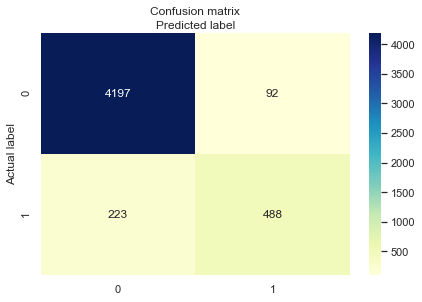

In [28]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(dtc.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

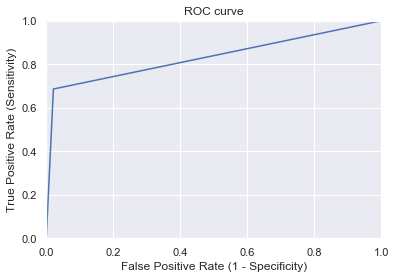

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predicted)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [30]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.94050
[fold 1] score: 0.93400
[fold 2] score: 0.95050
[fold 3] score: 0.94050
[fold 4] score: 0.93800

KNN mean score [5 folds] = 0.9407
